# Recency Frequency Monetary (RFM) Analysis

In [3]:

import math
import numpy as np
import pandas as pd
import datetime as dt
import seaborn as sns
from scipy.stats import norm
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score


### Dataset

This is a transactional data set which contains all the transactions occurring between 01/12/2010 and 09/12/2011 for a UK-based and registered non-store online retail.
	
https://archive.ics.uci.edu/ml/datasets/online+retail

**Attribute Information**:

    InvoiceNo: Invoice number. Nominal, a 6-digit integral number uniquely assigned to each transaction. If this code starts with letter 'c', it indicates a cancellation.
    StockCode: Product (item) code. Nominal, a 5-digit integral number uniquely assigned to each distinct product.
    Description: Product (item) name. Nominal.
    Quantity: The quantities of each product (item) per transaction. Numeric.
    InvoiceDate: Invice Date and time. Numeric, the day and time when each transaction was generated.
    UnitPrice: Unit price. Numeric, Product price per unit in sterling.
    CustomerID: Customer number. Nominal, a 5-digit integral number uniquely assigned to each customer.
    Country: Country name. Nominal, the name of the country where each customer resides. 

In [4]:
#df = pd.read_excel('http://archive.ics.uci.edu/ml/machine-learning-databases/00352/Online%20Retail.xlsx')
df = pd.read_excel('Online Retail.xlsx')
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [5]:
df.dtypes

InvoiceNo              object
StockCode              object
Description            object
Quantity                int64
InvoiceDate    datetime64[ns]
UnitPrice             float64
CustomerID            float64
Country                object
dtype: object

## Data Cleanup

In [6]:
df.describe()

,Quantity,UnitPrice,CustomerID
count,541909.000000,541909.000000,406829.000000
mean,9.552250,4.611114,15287.690570
std,218.081158,96.759853,1713.600303
min,-80995.000000,-11062.060000,12346.000000
25%,1.000000,1.250000,13953.000000
50%,3.000000,2.080000,15152.000000
75%,10.000000,4.130000,16791.000000
max,80995.000000,38970.000000,18287.000000


In [12]:
pip install missingno

Note: you may need to restart the kernel to use updated packages.


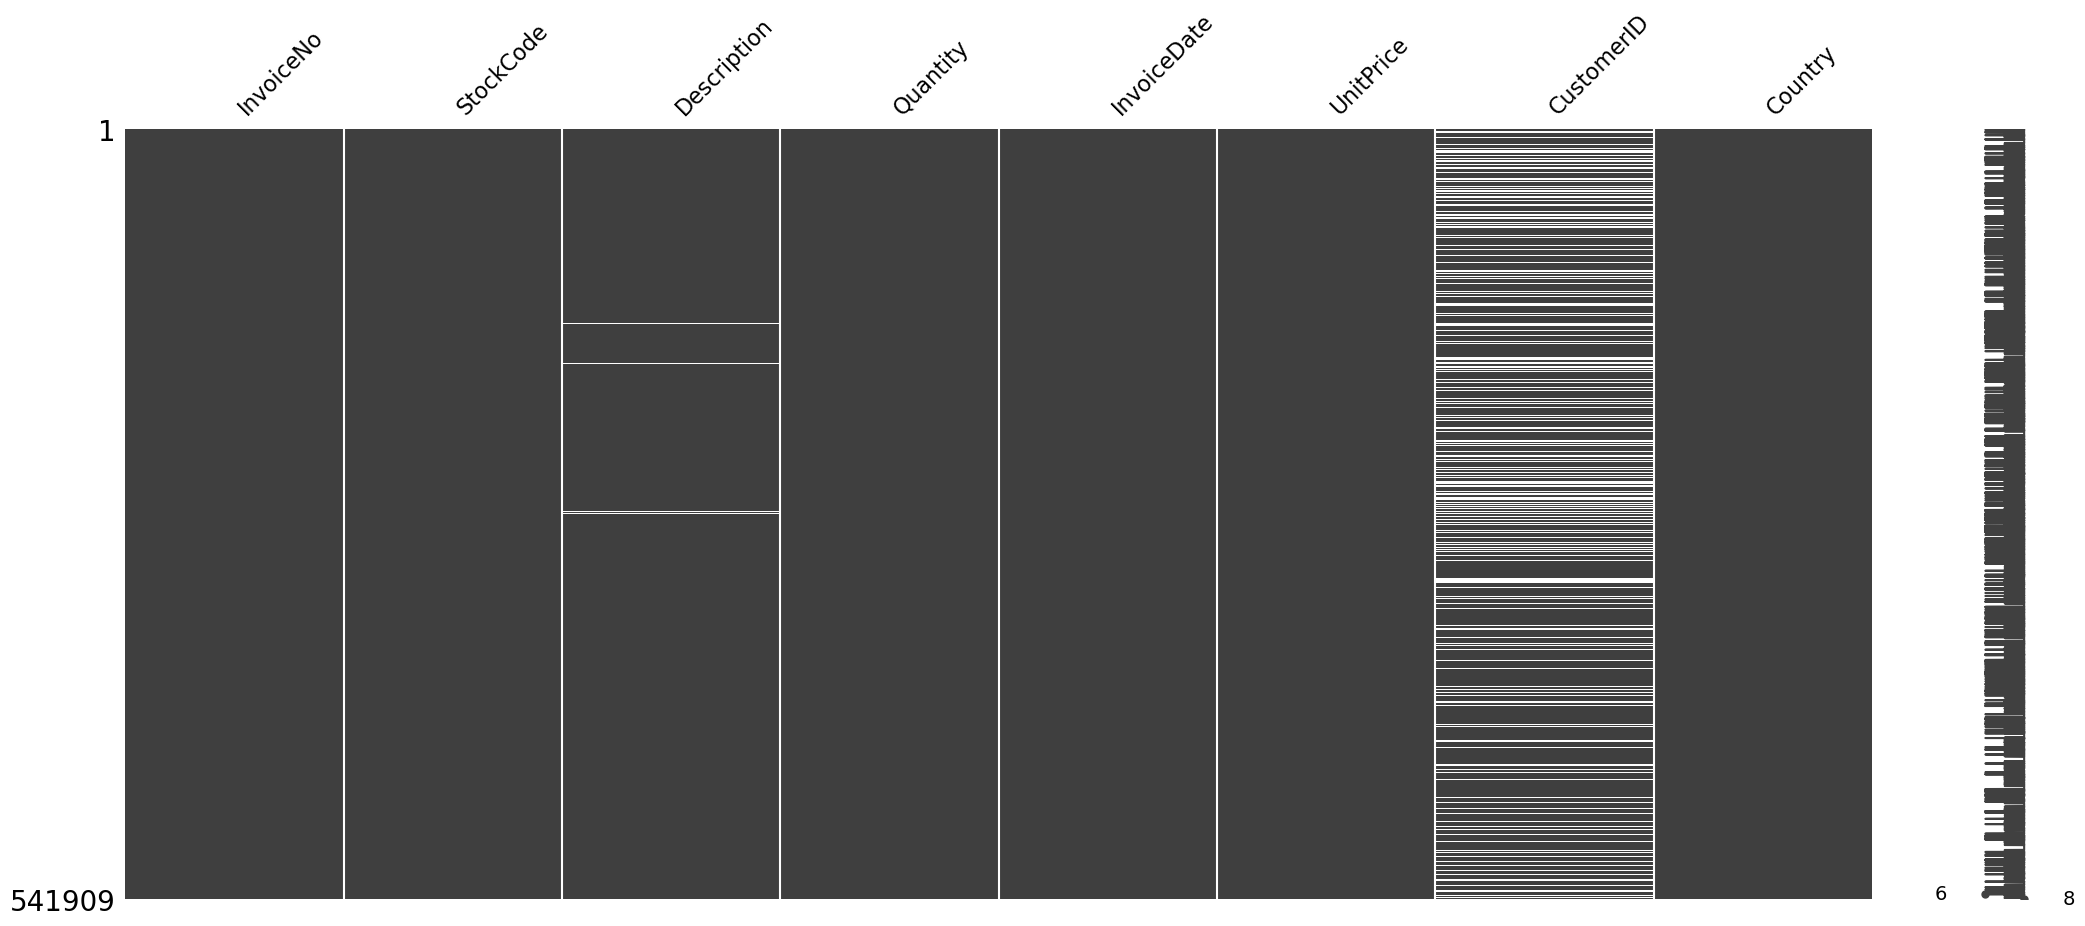

<Figure size 500x300 with 0 Axes>

In [13]:
#plot missing data
import missingno as msno
import matplotlib.pyplot as plt
msno.matrix(df)
plt.show(plt.figure(figsize=(5, 3)))

In [25]:
# get the missing data
missing_data = df.isnull().sum()
print(missing_data)

InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
TotalPrice     0
dtype: int64


In [45]:
# drop Description column
df.drop(columns=['Description'], inplace=True)

In [46]:
# drop rows with missing InvoiceNo
df.dropna(subset=['InvoiceNo'], inplace=True)
# drop rows with missing InvoiceDate
df.dropna(subset=['InvoiceDate'], inplace=True)
# drop rows with missing CustomerId
df.dropna(subset=['CustomerID'], inplace=True)
df.shape[0]

530104

In [47]:
#fix datatypes
df['CustomerID'] = df['CustomerID'].astype(str)
df['InvoiceNo'] = df['InvoiceNo'].astype(str)
# Convert 'InvoiceDate' column to datetime
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

In [48]:
#remove the credit transactions (those with invoice numbers containing C).
df = df[~df['InvoiceNo'].str.contains('C')]
df.shape[0]

530104

In [49]:
df = df[df['UnitPrice'] > 0]
df.shape[0]

530104

In [23]:
df.describe()

,Quantity,UnitPrice
count,530104.000000,530104.000000
mean,10.542037,3.907625
std,155.524124,35.915681
min,1.000000,0.001000
25%,1.000000,1.250000
50%,3.000000,2.080000
75%,10.000000,4.130000
max,80995.000000,13541.330000


## Exploratory Data Analysis

In [30]:
##countries
num_unique_countries = df['Country'].nunique()
print("##countries:", num_unique_countries)



##countries: 38


In [34]:
#Number of customers
num_unique_customerID = df['CustomerID'].nunique()
print("'CustomerID':", num_unique_customerID)



'CustomerID': 4339


In [ ]:
#Number of stockcodes

In [ ]:
#transcations by country

In [24]:
# TotalPrice column
df['TotalPrice'] = df['Quantity'] * df['UnitPrice']
df.sort_values(by='TotalPrice', ascending=False).head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalPrice
540421,581483,23843,"PAPER CRAFT , LITTLE BIRDIE",80995,2011-12-09 09:15:00,2.08,16446.0,United Kingdom,168469.60
61619,541431,23166,MEDIUM CERAMIC TOP STORAGE JAR,74215,2011-01-18 10:01:00,1.04,12346.0,United Kingdom,77183.60
222680,556444,22502,PICNIC BASKET WICKER 60 PIECES,60,2011-06-10 15:28:00,649.50,15098.0,United Kingdom,38970.00
15017,537632,AMAZONFEE,AMAZON FEE,1,2010-12-07 15:08:00,13541.33,nan,United Kingdom,13541.33
299982,A563185,B,Adjust bad debt,1,2011-08-12 14:50:00,11062.06,nan,United Kingdom,11062.06


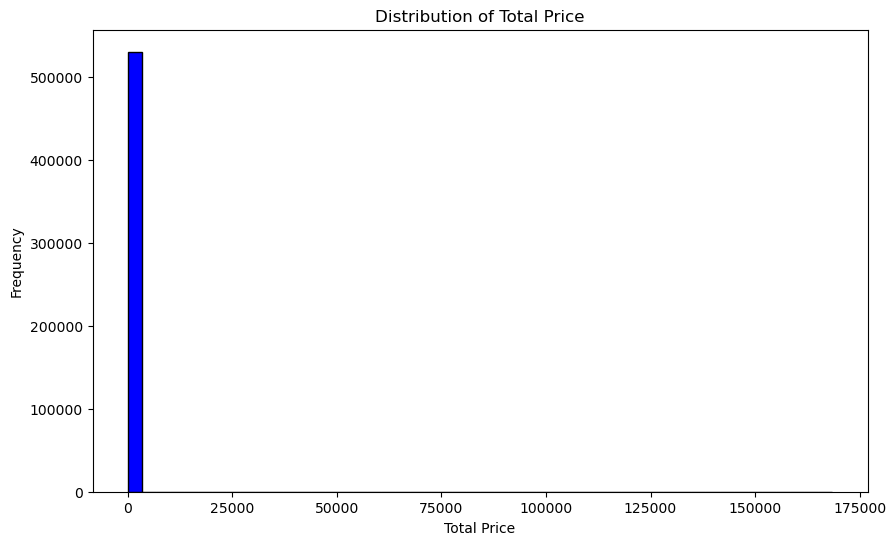

In [29]:
# Visualize the distribution of TotalPrice
import matplotlib.pyplot as plt

# Assuming 'df' is your DataFrame and 'TotalPrice' is already calculated
plt.figure(figsize=(10, 6))
plt.hist(df['TotalPrice'], bins=50, color='blue', edgecolor='black')
plt.title('Distribution of Total Price')
plt.xlabel('Total Price')
plt.ylabel('Frequency')
plt.show()


## RFM Analysis
Calculation of RFM metrics (recency, frequency, and monetary)
    
    recency = date of analysis - purchase date of the relevant customer
    frequency = customer's total number of purchases
    monetary = total monetary value as a result of the customer's total purchases
    
We will assume the date of analysis was 1 days after the max(date) in the dataset

In [35]:
# get the last invoice date in the dataset
max_date = df['InvoiceDate'].max()
max_date

Timestamp('2011-12-09 12:50:00')

In [36]:
# adding a day to the calculated max date as date of analysis
snapshot_date = max_date + dt.timedelta(days = 1)
snapshot_date

Timestamp('2011-12-10 12:50:00')

In [37]:
rfm = df.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (snapshot_date - x.max()).days, # Recency
    'InvoiceNo': 'count',                                    # Frequency
    'TotalPrice': 'sum' ,                                    # Monetary
})

rfm.rename(columns={'InvoiceDate': 'Recency', 'InvoiceNo': 'Frequency', 'TotalPrice': 'Monetary'}, inplace=True)

# Display the RFM table
rfm

,Recency,Frequency,Monetary
CustomerID,,,
12346.0,326,1,77183.60
12347.0,2,182,4310.00
12348.0,75,31,1797.24
12349.0,19,73,1757.55
12350.0,310,17,334.40
...,...,...,...
18281.0,181,7,80.82
18282.0,8,12,178.05
18283.0,4,756,2094.88


### Segmenting customers based on RFM scores

Create R, F, M scores from 1 (least) to 4 (higest)

<code>r_quartiles:</code> Generate labels in reverse order from 4 to 1. This means that the quartiles will be labeled as 4 for the first quartile (highest recency), 3 for the second quartile, 2 for the third quartile, and 1 for the fourth quartile (lowest recency). This reverse ordering might be chosen for interpretability, where higher values indicate better or more recent behavior.

In [38]:
# Define quartiles for Recency, Frequency, and Monetary
r_quartiles = pd.qcut(rfm['Recency'], q=4, labels=range(4, 0, -1))
f_quartiles = pd.qcut(rfm['Frequency'], q=4, labels=range(1, 5))
m_quartiles = pd.qcut(rfm['Monetary'], q=4, labels=range(1, 5))

rfm = rfm.assign(R=r_quartiles, F=f_quartiles, M=m_quartiles)

# Calculate RFM score
rfm['RFM_Score'] = rfm[['R', 'F', 'M']].sum(axis=1)
#rfm["RFM_Score"] = 0.6*rfm['F'] + 0.2*rfm['F'] + 0.2*rfm['M'] #alternative weighted score

# Define RFM segments
rfm['RFM_Segment'] = rfm[['R', 'F', 'M']].apply(lambda x: ''.join(map(str, x)), axis=1)

# Display the RFM table with segments
rfm

,Recency,Frequency,Monetary,R,F,M,RFM_Score,RFM_Segment
CustomerID,,,,,,,,
12346.0,326,1,77183.60,1,1,4,6,114
12347.0,2,182,4310.00,4,4,4,12,444
12348.0,75,31,1797.24,2,2,4,8,224
12349.0,19,73,1757.55,3,3,4,10,334
12350.0,310,17,334.40,1,1,2,4,112
...,...,...,...,...,...,...,...,...
18281.0,181,7,80.82,1,1,1,3,111
18282.0,8,12,178.05,4,1,1,6,411
18283.0,4,756,2094.88,4,4,4,12,444


In [39]:
#recency
rfm.Recency.describe()

count    4339.000000
mean       92.515326
std       100.012295
min         1.000000
25%        18.000000
50%        51.000000
75%       142.000000
max       374.000000
Name: Recency, dtype: float64

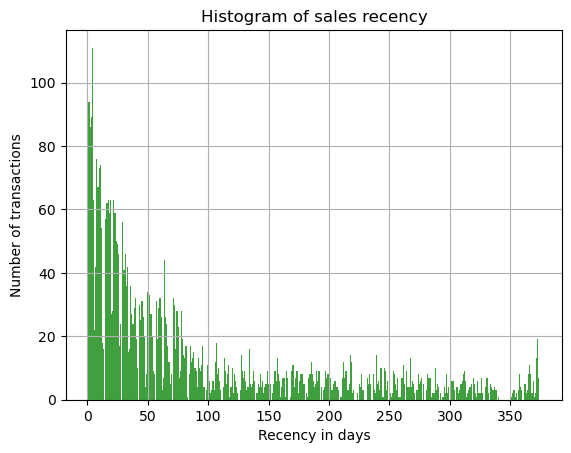

In [40]:
#Recency plot
x = rfm.Recency
mu = np.mean(rfm.Recency)
sigma = math.sqrt(np.var(rfm.Recency))
n, bins, patches = plt.hist(x, 400, facecolor='green', alpha=0.75)
plt.xlabel('Recency in days')
plt.ylabel('Number of transactions')
plt.title(r'Histogram of sales recency')
plt.grid(True)

In [41]:
rfm.groupby("RFM_Segment").count()


,Recency,Frequency,Monetary,R,F,M,RFM_Score
RFM_Segment,,,,,,,
111,385,385,385,385,385,385,385
112,104,104,104,104,104,104,104
113,24,24,24,24,24,24,24
114,10,10,10,10,10,10,10
121,99,99,99,99,99,99,99
...,...,...,...,...,...,...,...
434,86,86,86,86,86,86,86
441,3,3,3,3,3,3,3
442,16,16,16,16,16,16,16


In [42]:
#humanization
rfm.loc[(rfm['RFM_Score'] <= 4), 'Segment'] = 'Silver'
rfm.loc[(rfm['RFM_Score'] > 4) & (rfm['RFM_Score'] <= 7), 'Segment'] = 'Gold'
rfm.loc[(rfm['RFM_Score'] > 7) & (rfm['RFM_Score'] <= 10), 'Segment'] = 'Platinum'
rfm.loc[(rfm['RFM_Score'] > 10), 'Segment'] = 'Diamond'

rfm.head()

,Recency,Frequency,Monetary,R,F,M,RFM_Score,RFM_Segment,Segment
CustomerID,,,,,,,,,
12346.0,326,1,77183.60,1,1,4,6,114,Gold
12347.0,2,182,4310.00,4,4,4,12,444,Diamond
12348.0,75,31,1797.24,2,2,4,8,224,Platinum
12349.0,19,73,1757.55,3,3,4,10,334,Platinum
12350.0,310,17,334.40,1,1,2,4,112,Silver


In [50]:
# Calculate correlation matrix
#rfm_corr = rfm[['R' ,'F' ,'M']].corr()

# Create a heatmap
#plt.figure(figsize=(5, 3))
#sns.heatmap(rfm_corr, annot=True, cmap='coolwarm', fmt=".2f")
#plt.title('Correlation Heatmap')
#plt.show()

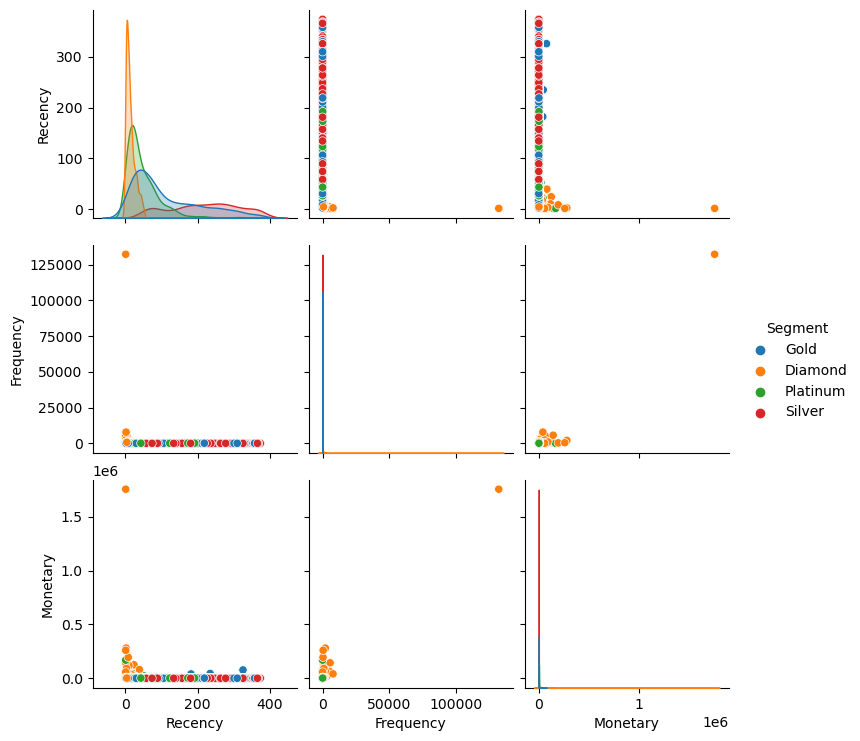

In [51]:
sns.pairplot(rfm[['Recency' ,'Frequency' ,'Monetary','Segment']], hue="Segment")
plt.show()

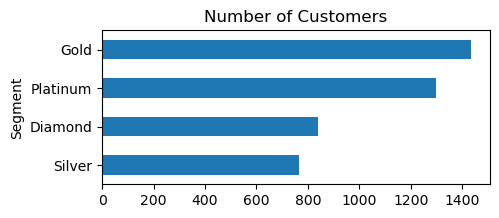

In [52]:
#group by topic and plot rows in the descending order
rfm.groupby('Segment').size().sort_values(ascending=True)\
    .plot(title="Number of Customers", kind='barh',figsize=(5,2))
plt.show()

## Sample Marketing Strategy

**Gold Customers:**
    
    - Exclusive Access: Early access to limited-edition products or special collections before they are available to other customers.
    - VIP Discounts: Higher discounts or special promotional codes applicable to select products or categories.
    - Dedicated Support: Assign a dedicated customer support representative or hotline to address their inquiries and resolve issues promptly.

**Silver Customers:**
    
    - Tier Upgrade Incentives: Incentives such as a one-time discount or bonus points for reaching the Gold tier.
    - Tier-specific Offers: Targeted offers on products complementary to their past purchases or interests.
    - Early Sale Access: Early access to seasonal sales or clearance events to encourage repeat purchases.

**Platinum Customers:**
    
    - Personal Shopper Service: Introduce a personalized shopping service with recommendations and assistance from a dedicated personal shopper.
    - Exclusive Events: Exclusive VIP events, such as product launches or fashion shows, with complimentary refreshments and VIP seating.
    - Customized Products: Option to customize products with monograms, engravings, or bespoke designs tailored to their preferences.

**Diamond Customers:**
    
    - Luxury Gifts: Surprise with luxury gifts or limited-edition items as a token of appreciation for their loyalty.
    - Private Consultations: Arrange private consultations with designers or industry experts to discuss bespoke or high-end purchases.
    - Elite Benefits: Elite benefits such as complimentary expedited shipping, priority access to customer support,

## Cluster Analysis 

Behavioral clustering involves grouping customers based on similarities in their behavior, preferences, or characteristics. It helps identify distinct customer segments that may not be evident from RFM analysis alone. 

Combining clustering and RFM analysis provides complementary insights into customer behavior. Clustering helps identify distinct customer segments, while RFM analysis identifies high-value customers within those segments. After clustering customers into segments, RFM analysis can be applied within each segment to identify differences in recency, frequency, and monetary value. This allows for segment-specific marketing strategies tailored to the unique characteristics of each cluster.

/Users/apple/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/apple/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/apple/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/apple/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 1

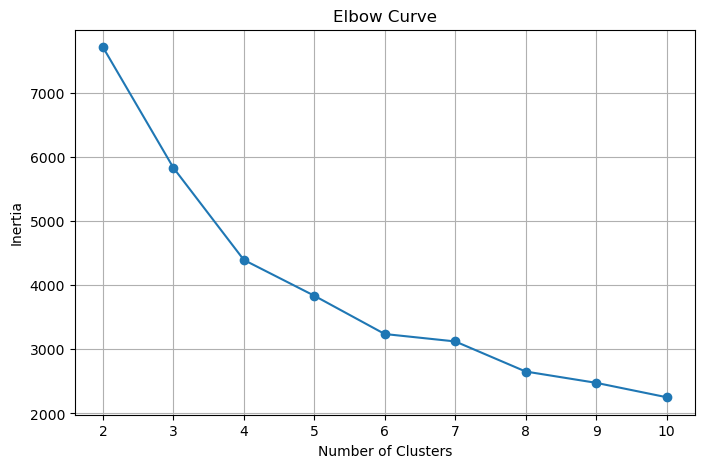

In [63]:
# Cluster the data based on RFM categories. Could we use a more elaborate clustering scheme ?
X = rfm[['R','F','M']] 
n_clusters = range(2,11,1)
cost = []
for i in n_cluster:
    model = KMeans(n_clusters =i, random_state=13)
    model.fit(X)
    cost.append(model.inertia_)
    
plt.figure(figsize=(8, 5))
plt.plot(n_clusters, cost, marker='o', linestyle='-')
plt.title('Elbow Curve')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.xticks(n_clusters)
plt.grid(True)
plt.show()

In [65]:
#k=4 gets better clusters, however take inputs from the business
k = 4
model = KMeans(n_clusters=k, init = 'k-means++', random_state = 2024)
y = model.fit_predict(X)
rfm["Cluster"] = y
rfm.head()

/Users/apple/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


,Recency,Frequency,Monetary,R,F,M,RFM_Score,RFM_Segment,Segment,Cluster
CustomerID,,,,,,,,,,
12346.0,326,1,77183.60,1,1,4,6,114,Gold,3
12347.0,2,182,4310.00,4,4,4,12,444,Diamond,0
12348.0,75,31,1797.24,2,2,4,8,224,Platinum,3
12349.0,19,73,1757.55,3,3,4,10,334,Platinum,0
12350.0,310,17,334.40,1,1,2,4,112,Silver,2


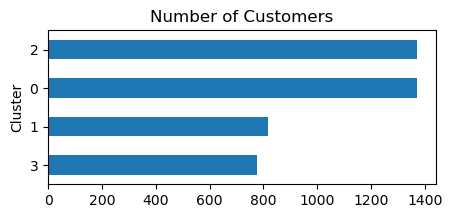

In [66]:
#group by topic and plot rows in the descending order
rfm.groupby('Cluster').size().sort_values(ascending=True)\
    .plot(title="Number of Customers", kind='barh',figsize=(5,2))
plt.show()